In [1]:
import numpy as np

import gc
import os
import sys
import matplotlib.pyplot as plt

sys.path.append("../")
sys.path.append("../03_experimental_data_chemical_shifts/")


import SRT_optimization as srt

from matplotlib.backends.backend_pdf import PdfPages
import scipy

import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

In [2]:
BMBR_path="../../../OLD_CORY/sds_vs_peptide/BMRB_experimental_data/"
def load_BMBR(BMBR_path:str):
    # load in experimental data
    experiments={}
    for root, dirs, files in os.walk(BMBR_path):
        if len(files)==1:
            file=root+"/"+files[0]
            with open(file,"r") as f:
                read_relaxations=False
                read_shifts=False
                counter_relaxations=0 # saves data when -1
                counter_shifts=0 # saves data when -1
                for idline,line in enumerate(f):
                    counter_relaxations+=1
                    counter_shifts+=1
                    if "_Entry.ID" in line:
                        ID=line.split()[1]
                        experiments[ID]={}
                        experiments[ID]["disordered"]=False
                        experiments[ID]["micelle"]=False
                        experiments[ID]["T2measur"]={}
                    if '_Heteronucl_T2_list.Sf_framecode' in line:
                        mesurment=line.split()[1]
                    if '_Heteronucl_T2_list.Sample_condition_list_label' in line:
                        condition=line.split()[1]
                        if condition not in experiments[ID]["T2measur"]:
                            experiments[ID]["T2measur"][condition]={}
                        experiments[ID]["T2measur"][condition][mesurment]={}
                    if "_Heteronucl_T2_list.Spectrometer_frequency_1H" in line:
                        field=line.split()[1]
                        try:
                            if float(field)>1100:
                                field=float(field)/1000000
                            experiments[ID]["T2measur"][condition][mesurment]['field']=float(field)
                        except:
                            print(ID,field)


                        
                        experiments[ID]["T2measur"][condition][mesurment]["results"]={}
                        experiments[ID]["T2measur"][condition][mesurment]["results"]["AA"]=[]
                        experiments[ID]["T2measur"][condition][mesurment]["results"]["atomID"]=[]
                        experiments[ID]["T2measur"][condition][mesurment]["results"]["R2"]=[]
                    
                    if "_Heteronucl_T2_list.T2_val_units" in line:
                        units=line.split()[1]
                        experiments[ID]["T2measur"][condition][mesurment]["units"]=units
                    if "_T2.Heteronucl_T2_list_ID" in line:
                        counter_relaxations=-3
                    if counter_relaxations==-1:
                        read_relaxations=True
                    if read_relaxations:
                        if len(line.split())==21:
                            experiments[ID]["T2measur"][condition][mesurment]['expType']=line.split()[7]
                            if experiments[ID]["T2measur"][condition][mesurment]["units"]=="s-1" or experiments[ID]["T2measur"][condition][mesurment]["units"]=="Hz":
                                try:
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["R2"].append(float(line.split()[10]))
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["AA"].append(line.split()[6])
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["atomID"].append(int(line.split()[5]))
                            
                                except:
                                    pass
                            elif experiments[ID]["T2measur"][condition][mesurment]["units"]=="s":
                                try:
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["R2"].append(1/float(line.split()[10]))
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["AA"].append(line.split()[6])
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["atomID"].append(int(line.split()[5]))
                            
                                except:
                                    pass
                            elif experiments[ID]["T2measur"][condition][mesurment]["units"]=="ms":
                                try:
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["R2"].append(1/float(line.split()[10])*1000)
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["AA"].append(line.split()[6])
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["atomID"].append(int(line.split()[5]))
                            
                                except:
                                    pass
                            elif experiments[ID]["T2measur"][condition][mesurment]["units"]=="ms-1":
                                try:
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["R2"].append(float(line.split()[10])/1000)
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["AA"].append(line.split()[6])
                                    experiments[ID]["T2measur"][condition][mesurment]["results"]["atomID"].append(int(line.split()[5]))
                            
                                except:
                                    pass
                        else:
                            read_relaxations=False
                    

                    if ("disorder" in line or "Disorder" in line):
                        experiments[ID]["disordered"]=True

                    if ("micelle" in line or "Micelle" in line):
                        experiments[ID]["micelle"]=True
                    if "_Assembly.Molecular_mass" in line:

                        if line.split()[1]!=".":
                            experiments[ID]["weight"]=float(line.split()[1])
                        else:
                            experiments[ID]["weight"]=None
    return experiments

In [3]:
experiments=load_BMBR(BMBR_path)

4697 .


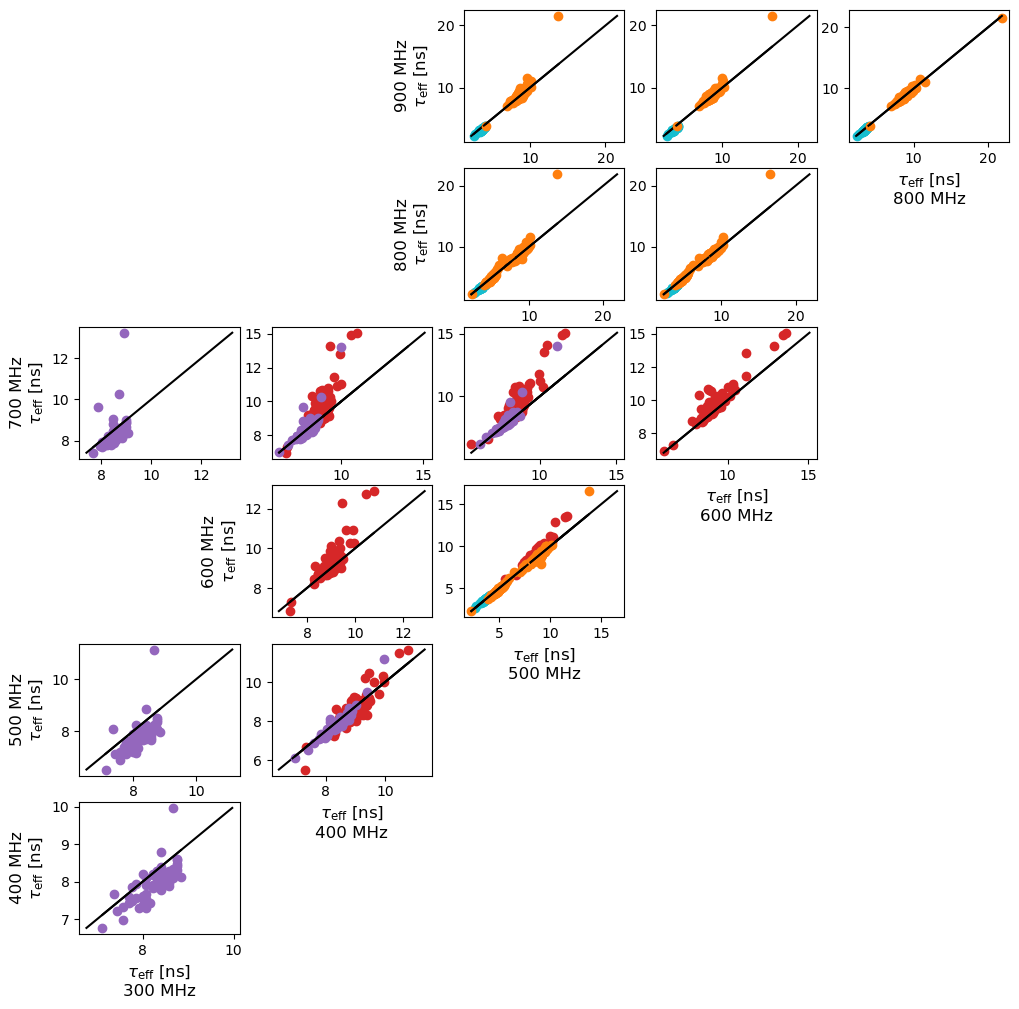

In [13]:
smallers={300:0, 400:1, 500:2, 600:3, 800:4}
biggers={400:5, 500:4, 600:3, 700:2, 800:1, 900:0}

fig = plt.figure(figsize=(12,12))
outer = gridspec.GridSpec(6,5, hspace=0.2, wspace=0.2)
axs={}
axs[0,2]=plt.Subplot(fig, outer[2])
axs[0,3]=plt.Subplot(fig, outer[3])
axs[0,4]=plt.Subplot(fig, outer[4])


axs[1,2]=plt.Subplot(fig, outer[7])
axs[1,3]=plt.Subplot(fig, outer[8])
axs[2,0]=plt.Subplot(fig, outer[10])
axs[2,1]=plt.Subplot(fig, outer[11])
axs[2,2]=plt.Subplot(fig, outer[12])
axs[2,3]=plt.Subplot(fig, outer[13])
axs[3,1]=plt.Subplot(fig, outer[16])
axs[3,2]=plt.Subplot(fig, outer[17])
axs[4,0]=plt.Subplot(fig, outer[20])
axs[4,1]=plt.Subplot(fig, outer[21])
axs[5,0]=plt.Subplot(fig, outer[25])
for i in axs:
    fig.add_subplot(axs[i])
    axs[i].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    #axs[i].set_ylim(1,23)
    #axs[i].set_xlim(1,23)
    #if i[0]==0:
    #    axs[i].set_ylim(1,23)
    #    if i[1]>2:
    #        axs[i].set_yticklabels([])
    
    
for i,entry in enumerate(experiments):
    #if entry!='4697':
    if entry in ['18864','16360','26845','6243']:
        #if entry in ['26845']:
        for condition in experiments[entry]['T2measur']:
            if len(experiments[entry]['T2measur'][condition])>1:
                #print(entry)
                fields={}
                for meas in experiments[entry]['T2measur'][condition]:
                    if experiments[entry]['T2measur'][condition][meas]['expType'] == 'N':
                        fields[experiments[entry]['T2measur'][condition][meas]['field']]=meas
                fields=dict(sorted(fields.items()))

                for smaller_c in fields:
                    for bigger_c in fields:
                        if bigger_c>smaller_c:

                            if int(float(smaller_c))%10==0:
                                smaller=(int(float(smaller_c)))
                                smaller_s=smaller_c
                            else:
                                smaller=(int(float(smaller_c)))+1
                                smaller_s=smaller_c
                            if int(float(bigger_c))%10==0:
                                bigger=(int(float(bigger_c)))
                                bigger_s=bigger_c
                            else:
                                bigger=(int(float(bigger_c)))+1
                                bigger_s=bigger_c


                            small=[]
                            for R2 in experiments[entry]['T2measur'][condition][fields[smaller_c]]["results"]["R2"]:
                                try:
                                    #small.append(srt.find_tau_from_R2_np_poly1d(float(smaller_s),float(R2))*10**9)
                                    small.append(srt.find_tau_from_R2_hyperbolic_approximation(float(smaller_s),float(R2))*10**9)
                                except :
  
                                    small.append(None)



                            big=[]
                            for R2 in experiments[entry]['T2measur'][condition][fields[bigger_c]]["results"]["R2"]:
                                try:
                                    #big.append(srt.find_tau_from_R2_np_poly1d(float(bigger_s),float(R2))*10**9)
                                    big.append(srt.find_tau_from_R2_hyperbolic_approximation(float(bigger_s),float(R2))*10**9)
                                except:
                                    big.append(None)
                            
                            S=[]
                            B=[]
                            for pos,res in enumerate(experiments[entry]['T2measur'][condition][fields[smaller_c]]["results"]["atomID"]):
                                if res in experiments[entry]['T2measur'][condition][fields[bigger_c]]["results"]["atomID"]:
                                    pos_big=experiments[entry]['T2measur'][condition][fields[bigger_c]]["results"]["atomID"].index(res)
                                    if not small[pos]==None and not big[pos_big]==None:
                                        if experiments[entry]['T2measur'][condition][fields[smaller_c]]["results"]["AA"][pos]==experiments[entry]['T2measur'][condition][fields[bigger_c]]["results"]['AA'][pos_big]:
                                            axs[biggers[bigger],smallers[smaller]].plot(small[pos],big[pos_big],"o",c="C"+str(i//2+2))
                                            S.append(small[pos])
                                            B.append(big[pos_big])
                            axs[biggers[bigger],smallers[smaller]].plot([min(S),max(S)],[min(S),max(S)],'-',c='black')  
                            axs[biggers[bigger],smallers[smaller]].plot([min(B),max(B)],[min(B),max(B)],'-',c='black')  

                            

axs[0,2].set_ylabel('900 MHz\n' r'$\tau_{\mathrm{eff}}$ [ns]',size=12)
axs[1,2].set_ylabel('800 MHz\n' r'$\tau_{\mathrm{eff}}$ [ns]',size=12)
axs[2,0].set_ylabel('700 MHz\n' r'$\tau_{\mathrm{eff}}$ [ns]',size=12)
axs[3,1].set_ylabel('600 MHz\n' r'$\tau_{\mathrm{eff}}$ [ns]',size=12)
axs[4,0].set_ylabel('500 MHz\n' r'$\tau_{\mathrm{eff}}$ [ns]',size=12)
axs[5,0].set_ylabel('400 MHz\n' r'$\tau_{\mathrm{eff}}$ [ns]',size=12)

axs[5,0].set_xlabel(r'$\tau_{\mathrm{eff}}$ [ns]' '\n300 MHz',size=12)
axs[4,1].set_xlabel(r'$\tau_{\mathrm{eff}}$ [ns]' '\n400 MHz',size=12)
axs[3,2].set_xlabel(r'$\tau_{\mathrm{eff}}$ [ns]' '\n500 MHz' ,size=12)
axs[2,3].set_xlabel(r'$\tau_{\mathrm{eff}}$ [ns]' '\n600 MHz' ,size=12)
axs[0,4].set_xlabel(r'$\tau_{\mathrm{eff}}$ [ns]' '\n800 MHz' ,size=12)

plt.savefig("field_dependency_lin_approx_corr_4fields_new.pdf")

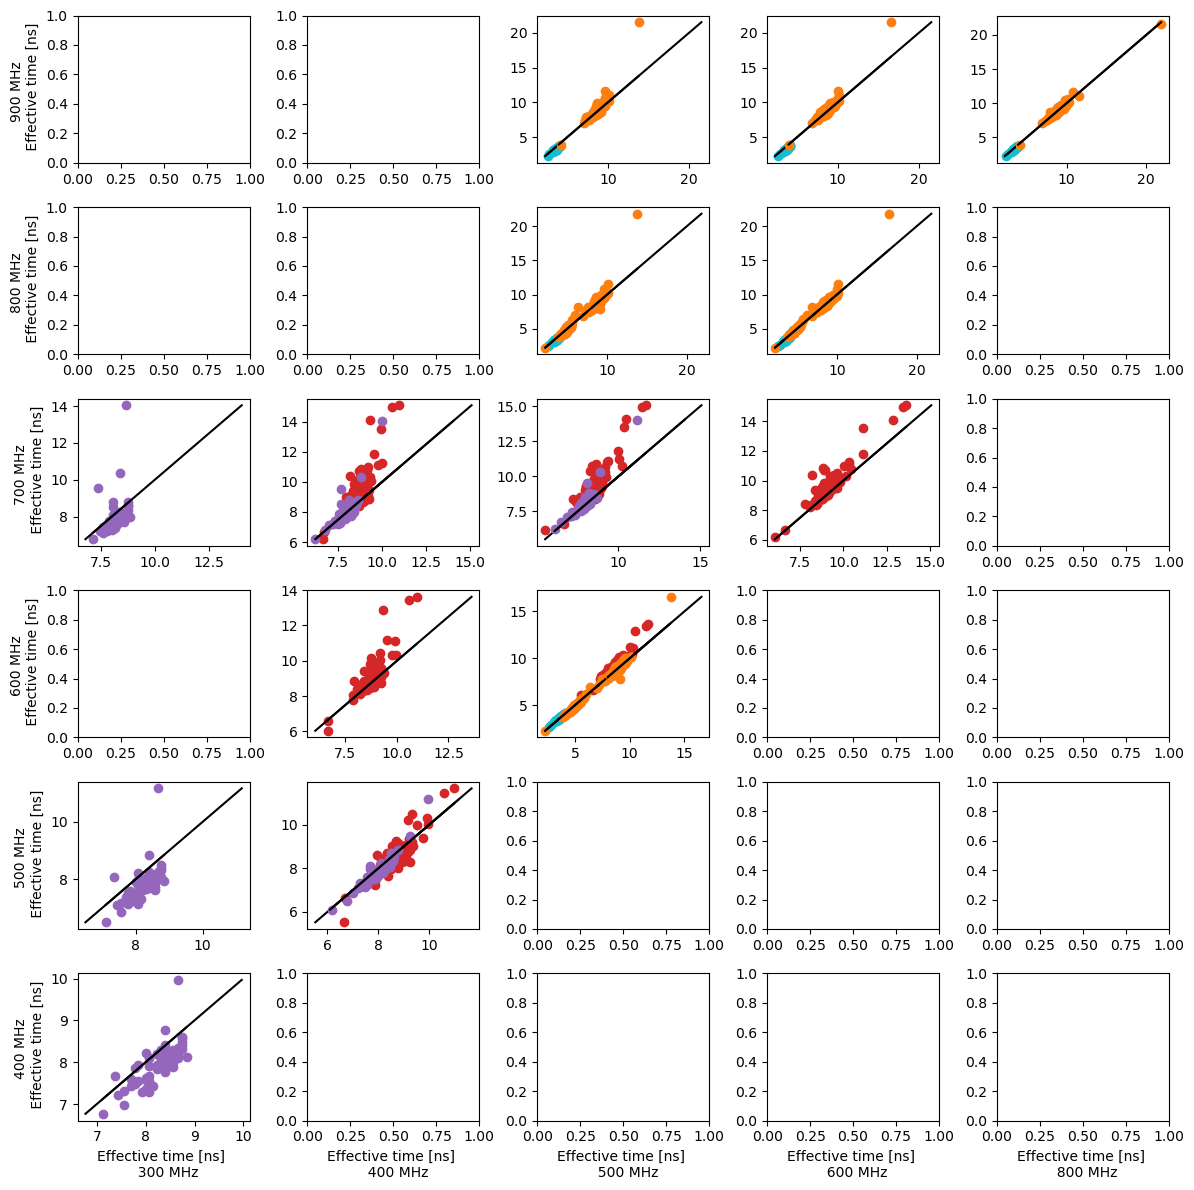

In [4]:
plt.rcParams["figure.autolayout"] = True
smallers={300:0, 400:1, 500:2, 600:3, 800:4}
biggers={400:5, 500:4, 600:3, 700:2, 800:1, 900:0}




fig, axs = plt.subplots(6,5,figsize=(12,12),sharex=False, sharey=False)

for i,entry in enumerate(experiments):
    #if entry!='4697':
    if entry in ['18864','16360','26845','6243']:
        #if entry in ['26845']:
        for condition in experiments[entry]['T2measur']:
            if len(experiments[entry]['T2measur'][condition])>1:
                #print(entry)
                fields={}
                for meas in experiments[entry]['T2measur'][condition]:
                    if experiments[entry]['T2measur'][condition][meas]['expType'] == 'N':
                        fields[experiments[entry]['T2measur'][condition][meas]['field']]=meas
                fields=dict(sorted(fields.items()))

                for smaller_c in fields:
                    for bigger_c in fields:
                        if bigger_c>smaller_c:

                            if int(float(smaller_c))%10==0:
                                smaller=(int(float(smaller_c)))
                                smaller_s=smaller_c
                            else:
                                smaller=(int(float(smaller_c)))+1
                                smaller_s=smaller_c
                            if int(float(bigger_c))%10==0:
                                bigger=(int(float(bigger_c)))
                                bigger_s=bigger_c
                            else:
                                bigger=(int(float(bigger_c)))+1
                                bigger_s=bigger_c


                            small=[]
                            for R2 in experiments[entry]['T2measur'][condition][fields[smaller_c]]["results"]["R2"]:
                                try:
                                    #small.append(srt.find_tau_from_R2_np_poly1d(float(smaller_s),float(R2))*10**9)
                                    small.append(srt.find_tau_from_R2_hyperbolic_approximation(float(smaller_s),float(R2))*10**9)
                                except :
  
                                    small.append(None)



                            big=[]
                            for R2 in experiments[entry]['T2measur'][condition][fields[bigger_c]]["results"]["R2"]:
                                try:
                                    #big.append(srt.find_tau_from_R2_np_poly1d(float(bigger_s),float(R2))*10**9)
                                    big.append(srt.find_tau_from_R2_hyperbolic_approximation(float(bigger_s),float(R2))*10**9)
                                except:
                                    big.append(None)
                            
                            S=[]
                            B=[]
                            for pos,res in enumerate(experiments[entry]['T2measur'][condition][fields[smaller_c]]["results"]["atomID"]):
                                if res in experiments[entry]['T2measur'][condition][fields[bigger_c]]["results"]["atomID"]:
                                    pos_big=experiments[entry]['T2measur'][condition][fields[bigger_c]]["results"]["atomID"].index(res)
                                    if not small[pos]==None and not big[pos_big]==None:
                                        if experiments[entry]['T2measur'][condition][fields[smaller_c]]["results"]["AA"][pos]==experiments[entry]['T2measur'][condition][fields[bigger_c]]["results"]['AA'][pos_big]:
                                            axs[biggers[bigger],smallers[smaller]].plot(small[pos],big[pos_big],"o",c="C"+str(i//2+2))
                                            S.append(small[pos])
                                            B.append(big[pos_big])
                            axs[biggers[bigger],smallers[smaller]].plot([min(S),max(S)],[min(S),max(S)],'-',c='black')  
                            axs[biggers[bigger],smallers[smaller]].plot([min(B),max(B)],[min(B),max(B)],'-',c='black')  

                            



for xlabel,column in smallers.items():
    axs[5,column].set_xlabel(f'Effective time [ns] \n  {xlabel} MHz')
    
for ylabel,row in biggers.items():
    axs[row,0].set_ylabel(f'{ylabel} MHz \n Effective time [ns]')
    

In [5]:
axs={}
axs[0,0]=1
axs[0,1]=1
axs[0,2]=1

In [6]:
for i in axs:
    print(i)

(0, 0)
(0, 1)
(0, 2)
